# Mod 5 Project - Supervised Learning

## Intro

In this project I will be utilizing supervised learning methods to construct a predictive model that estimates whether a patient is likely to be readmitted in the future and other discharge outcomes for inpatients being treated for diabetes. The goal of this model will be to provide hospitals with a better understanding of which diagnoses work best for keeping the patient out of readmission.

## Libraries

Below you will see the Python libraries needed to conduct this exercise.

Some libraries of note are: 
- XX and YY used for data visualization.
- sklearn, a library with many ML packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from IPython.display import Image
from pydotplus import graph_from_dot_data

import warnings
warnings.filterwarnings("ignore")

## The data

### Sourcing

The dataset selected for this project come from the Center for Clinical and Translational Research at Virginia Commonwealth University. Data was sourced from the UC Irvine Machine Learning Repository and can be found here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008. The data represent 10 years (1999 - 2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. The data exhibit encounters that satisfy the following criteria:

- It is an inpatient encounter (a hospital admission).
- It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
- The length of stay was at least 1 day and at most 14 days.
- Laboratory tests were performed during the encounter.
- Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

A full list of feature descriptions can be found here: https://drive.google.com/file/d/1SSeT_sWLBoluq-24teF5BQ4lwMkWxWHU/view?usp=sharing

Value ID mapping for the variables admission_type_id, discharge_disposition_id, and admission_source_id can be found here: https://drive.google.com/file/d/19amgd_HmmsoUIr2TCmSpnkD9fWQqVOTE/view?usp=sharing

The target variable will be 'readmitted', which classifies whether the patient was readmitted within 30 days, after 30 days had passed, or there was no record of readmission.

In [2]:
df = pd.read_csv('diabetic_data.csv')

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Cleaning

I'll be following the OSEMN process on this project to Obtain, Scrub, Explore, Model, and Interpret the data. Now that I have obtained the data I will scrub it and put the values into a format Python can work with.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [5]:
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

I can see that I don't have any N/A values, but in the preview of the data I could see that there were character values ('?') in the weight column, so I will likely experience other columns with 'missing information' values.

From the Feature Description table (linked above) I understand that I am missing 97% of the values for weight, 53% of values for the feature identifying the medical specialty of the admitting physician, 52% of the values describing the payer code for the medical insurance/coverage of the patient, and 2% of the Race feature.

In spite of having this information, I will run a check on all feature contents and deal with missing values accordingly below.

In [6]:
cols = [i for i in df.columns]
for col in cols:
    print(df[col].value_counts())

96210942     1
89943846     1
384306986    1
94650156     1
83156784     1
2674482      1
281345844    1
193616274    1
355508024    1
165973818    1
125278944    1
420873188    1
157241154    1
161161032    1
174855390    1
134950734    1
154128210    1
96993108     1
122064144    1
297770840    1
382612616    1
165134172    1
108244830    1
210578766    1
443842340    1
151469730    1
289146210    1
154590960    1
145948404    1
176328594    1
            ..
249722520    1
111830682    1
126506652    1
80193186     1
186881700    1
147162726    1
263120844    1
249665124    1
151295556    1
113303472    1
73909806     1
422050106    1
13655088     1
168523320    1
296140568    1
98784828     1
157333056    1
280536642    1
130655706    1
190162530    1
107017800    1
103828530    1
176744010    1
172279374    1
297285200    1
74454612     1
208073976    1
166229592    1
38340702     1
77856768     1
Name: encounter_id, Length: 101766, dtype: int64
88785891     40
43140906     28
2319

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64
No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64
No        101765
Steady         1
Name: acetohexamide, dtype: int64
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64
No        101743
Steady        23
Name: tolbutamide, dtype: int64
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64
No

Takeaways:
- Encounter_Id is unique, meaning each visit to the hospital was separately identified.
- Patient_nbr was not unique, meaning some patients were readmitted, up to 40 times.
- 2,273 cases of Race not being identified. I will either drop those 2% of data or reclassify to 'Not Specified'
- 3 cases of unknown gender. Those will be dropped.
- Majority of patients are above the age of 50.
- Weight will likely be dropped as a feature.
- Given the high uncertainty in the payer_code and medical_specialty, those features will also be dropped.
- Diag_3 has '?' values, which could indicate the presence of those in the other diag features.
- Given the low occurrence of some of the drugs (e.g. metformin-pioglitazone), I will likely drop some of those as features.

In [7]:
#generate a copy of the data
data = df

In [8]:
dd = data.drop_duplicates('patient_nbr', keep='first')
dd.readmitted.value_counts()

NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64

I wanted to see how dropping the duplicate patient numbers would impact the results on the target variable. There was some concern that patients with more than one visit would disproportionately have target values that were not 'NO'. That does not seem to be the case. 39% of the duplicate valued patients had a readmit result of 'No', compared to the 54% of all data that make up the 'No' readmit. For now I will move forward with all data, but might model without duplicate values to see if there is a significant difference.

In [9]:
#Drop the rows where Race is not specified
data = data[data['race'] != '?']

In [10]:
#Drop the rows where Gender is not specified
data = data[data['gender'] != 'Unknown/Invalid']

In [11]:
#Drop the columns with a significant number of missing values
data = data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [12]:
cols = [i for i in dd.columns[20:]]
for col in cols:
    print(dd[col].value_counts())

250       9039
401       6588
276       3448
428       2847
427       2707
414       2669
496       1653
272       1633
403       1303
599       1283
?         1225
585        949
250.02     917
780        917
V45        892
285        851
424        797
707        795
425        723
305        707
584        665
250.6      663
250.01     653
518        587
278        559
682        547
41         521
493        507
530        472
244        413
          ... 
27           1
E825         1
164          1
952          1
V06          1
460          1
930          1
E852         1
195          1
841          1
E966         1
361          1
622          1
875          1
876          1
854          1
480          1
E861         1
148          1
524          1
989          1
951          1
880          1
141          1
385          1
971          1
171          1
669          1
890          1
123          1
Name: diag_3, Length: 759, dtype: int64
9     31740
5      8941
6      7691
7      76

In [13]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [14]:
#After controlling for patient duplicates, the following medications only have 
#the indicated number of patients prescribed or experiencing a change in 
#prescription. I am keeping any medication that has at least 30 patients 
#prescribed and dropping those listed below

# 'metformin-pioglitazone' #1
# 'metformin-rosiglitazone' #2
# 'glimepiride-pioglitazone' #None
# 'glipizide-metformin' #7
# 'citoglipton' #None
# 'examide' #None
# 'troglitazone' #3
# 'miglitol' #20
# 'tolbutamide' #19
# 'acetohexamide' #1

#I'm electing to drop the diagnosis data for now. The feature ids are not
#meaningful as continuous variables, and there are a significant number to 
#retain and construct categorical outcomes for. There is some potential to 
#reintroduce the diagnosis when exploring outcomes.

data = data.drop(['admission_source_id', 'diag_1', 'diag_2', 'diag_3', 
                  'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide', 
                  'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
                  'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                  'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
                  'examide', 'citoglipton', 'glyburide-metformin', 
                  'glipizide-metformin', 'glimepiride-pioglitazone', 
                  'metformin-rosiglitazone', 'metformin-pioglitazone', 
                  'diabetesMed'], axis=1)

In [ ]:
#data = data.set_index('encounter_id')

To be continued...

### Exploring

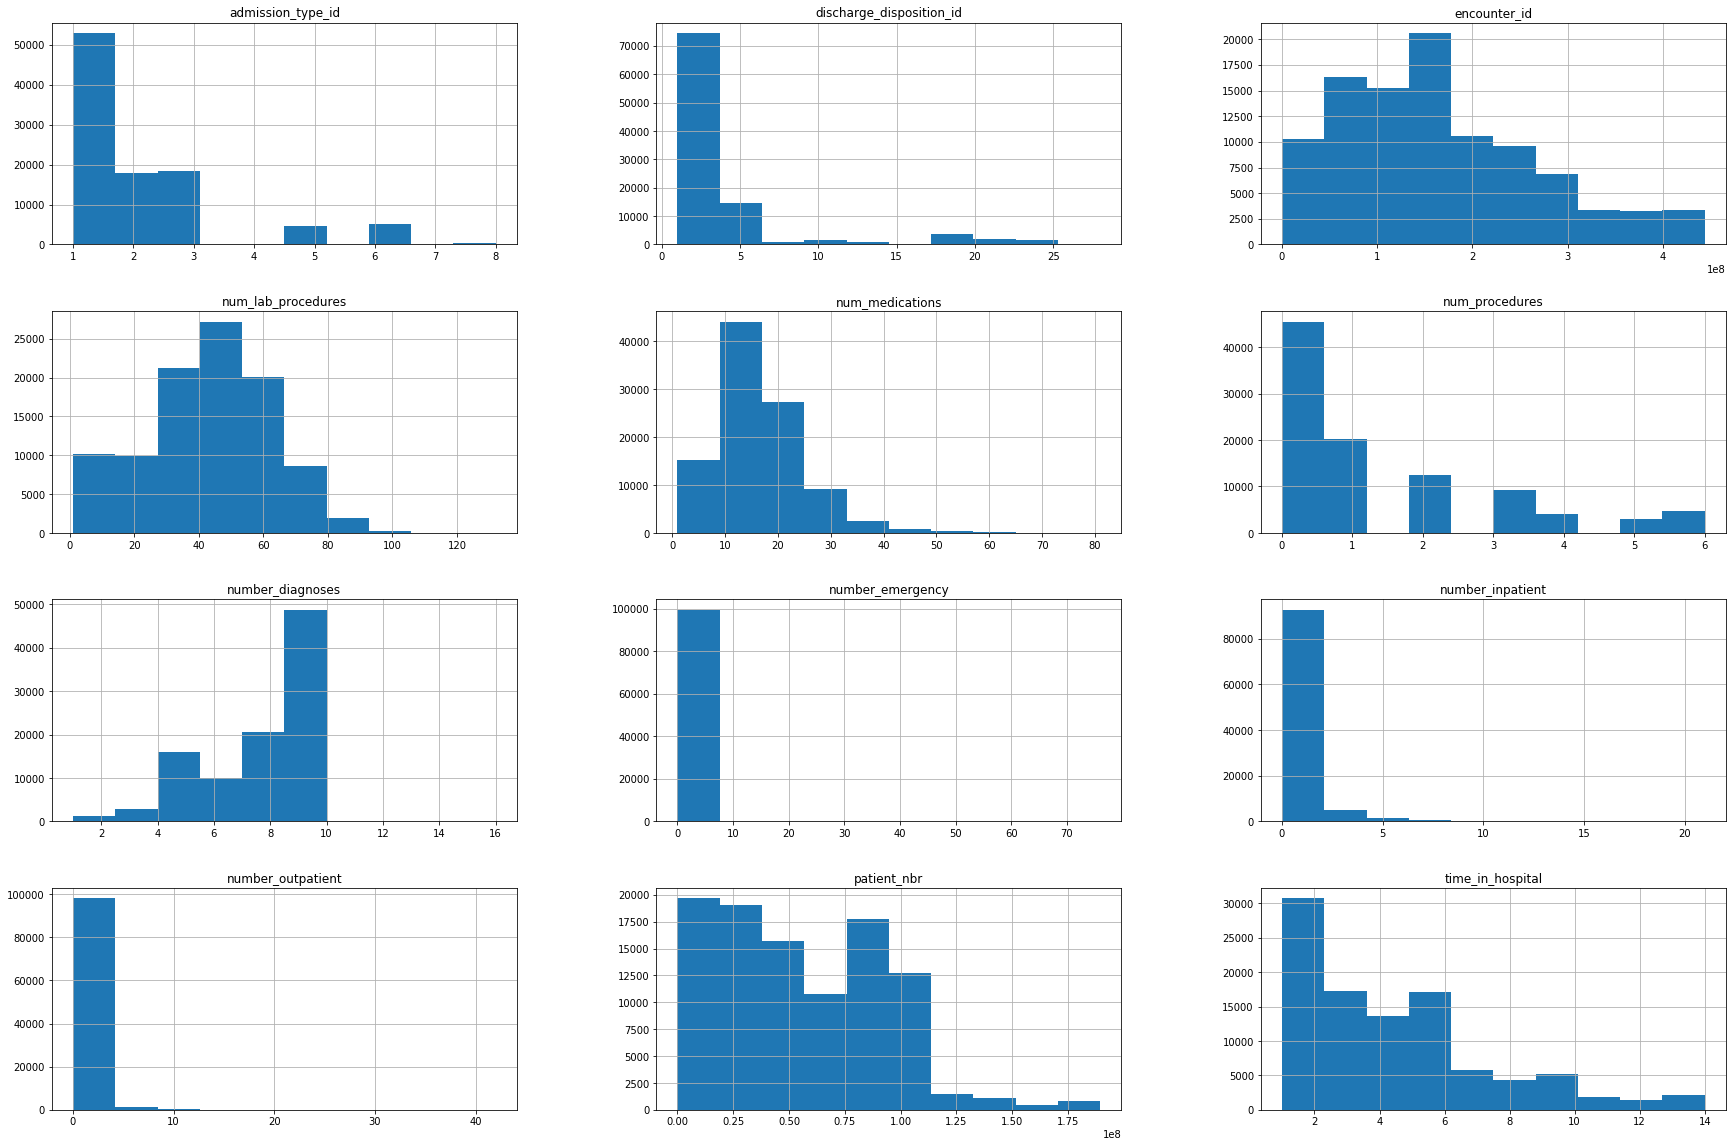

In [16]:
feat = data
feat.hist(figsize=(30,20));

In [ ]:
# These are all of the variables I want to keep.
# a = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 
#      'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 
#      'num_lab_procedures', 'num_procedures', 'num_medications', 
#      'number_outpatient', 'number_emergency', 'number_inpatient', 
#      'number_diagnoses', 'A1Cresult', 'insulin', 'readmitted']

In [ ]:
# These are all of the variables that are categorical.
# a = ['race', 'gender', 'age', 'admission_type_id', 
#      'discharge_disposition_id', 'A1Cresult', 'insulin', 'change']

In [ ]:
# a = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 
#      'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#      'time_in_hospital', 'num_lab_procedures', 'num_procedures',
#      'num_medications', 'number_outpatient', 'number_emergency',
#      'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
#      'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#      'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
#      'rosiglitazone', 'acarbose', 'tolazamide', 'insulin',
#      'glyburide-metformin', 'change', 'diabetesMed', 'readmitted']

In [17]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'insulin', 'change', 'readmitted'],
      dtype='object')

In [18]:
a = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 
     'A1Cresult', 'insulin', 'change']

In [19]:
b = {}
for i in a:
    b[i] = pd.get_dummies(data[i], prefix=i)

In [20]:
data = data.drop(a, axis=1)

In [21]:
data.head()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
0,2278392,8222157,1,41,0,1,0,0,0,1,NO
1,149190,55629189,3,59,0,18,0,0,0,9,>30
2,64410,86047875,2,11,5,13,2,0,1,6,NO
3,500364,82442376,2,44,1,16,0,0,0,7,NO
4,16680,42519267,1,51,0,8,0,0,0,5,NO


In [22]:
for key in b:
    data = pd.merge(data, 
                    b[key], 
                    how='outer', 
                    left_on=data.index,
                    right_on=b[key].index)
    data = data.drop('key_0', axis=1)

In [23]:
data = data.set_index('encounter_id')

In [24]:
data = data.dropna(axis=0)

In [44]:
data.shape

(97287, 71)

In [25]:
X = data.drop('readmitted', axis=1)
y = data.readmitted

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [27]:
classifier = DecisionTreeClassifier(criterion='entropy', max_depth= 10, random_state=123)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [28]:
y_pred = classifier.predict(X_test)

In [43]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy is :{0}'.format(acc))

# # Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :55.961680782830356

Confusion Matrix
----------------


Predicted,<30,>30,NO,All
True,,,,
<30,96,1011,1624,2731
>30,136,2954,5550,8640
NO,80,2310,10561,12951
All,312,6275,17735,24322


In [31]:
data.shape

(97287, 71)

In [42]:
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(X_train)
principalComponents = pca_2.fit_transform(X_train)
principalComponents = pca_3.fit_transform(X_train)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9999999999999993
0.9999999999999999
0.9999999999999999


In [40]:
data.loc[2278392.0]

patient_nbr                    8.22216e+06
time_in_hospital                         1
num_lab_procedures                      41
num_procedures                           0
num_medications                          1
number_outpatient                        0
number_emergency                         0
number_inpatient                         0
number_diagnoses                         1
readmitted                              NO
race_AfricanAmerican                     0
race_Asian                               0
race_Caucasian                           1
race_Hispanic                            0
race_Other                               0
gender_Female                            1
gender_Male                              0
age_[0-10)                               1
age_[10-20)                              0
age_[20-30)                              0
age_[30-40)                              0
age_[40-50)                              0
age_[50-60)                              0
age_[60-70)

In [ ]:
classifier_2 = DecisionTreeClassifier(random_state=10, criterion='entropy')  
classifier_2.fit(X_train, y_train)

In [ ]:
# Create DOT data
dot_data = export_graphviz(classifier_2, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

In [ ]:
# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())